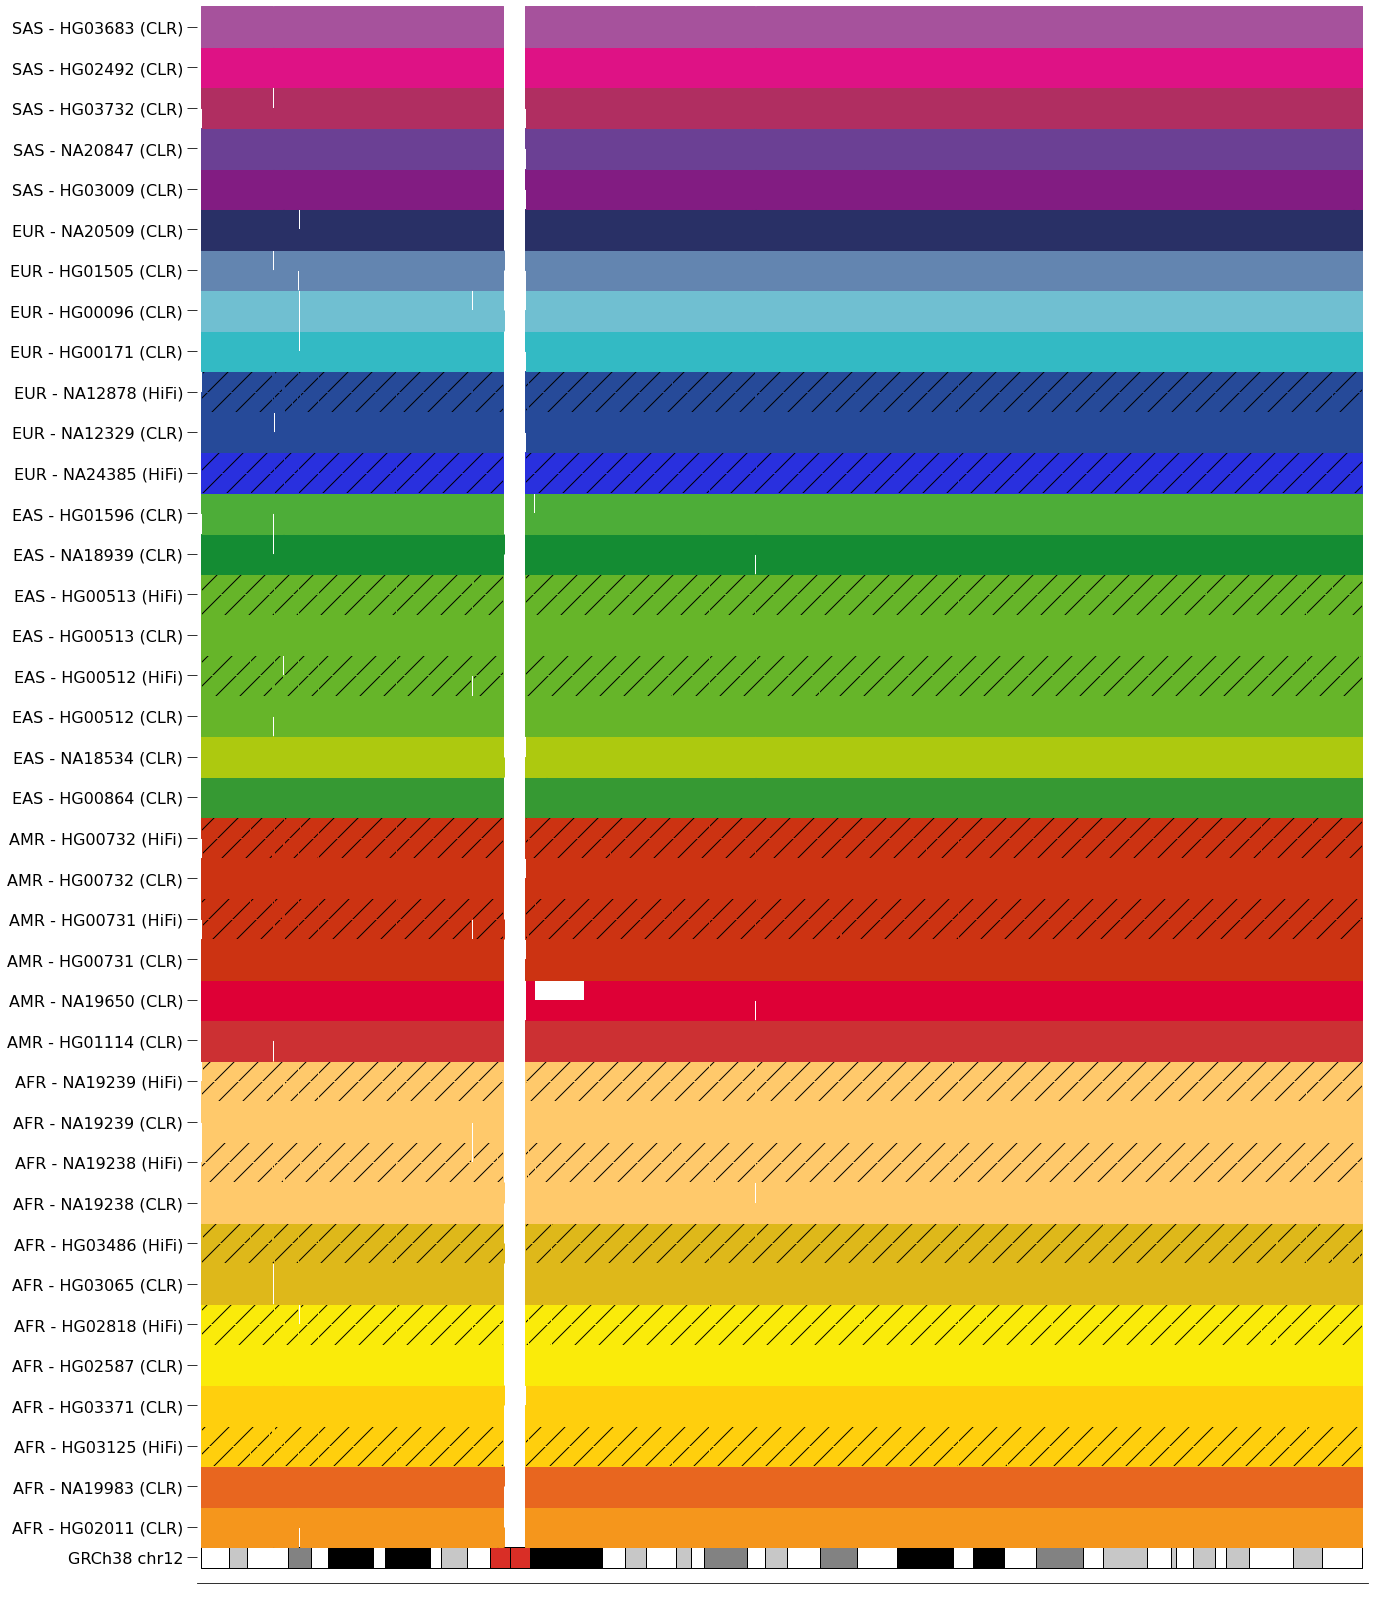

In [31]:
import os
import re
import importlib

import pandas as pd
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()

rgb_rel = plot_aux.relative_rgb
rel_rgb = rgb_rel

ref_contigs = '/home/local/work/pipeline/run_folder/references/assemblies/GRCh38_HGSVC2_incalt.sizes'
contig_aln_folder = '/home/local/work/data/hgsvc/contig_aln_bed_incalt'

save_fig = False
min_mapq = 60
select_chrom = 'chr12'

# color definitions
white = (1, 1, 1)
greys = [
    rgb_rel((204,204,204)),
    rgb_rel((150,150,150))
]
purples = [
    rgb_rel((203,201,226)),
    rgb_rel((158,154,200))
]

def load_contig_alignments(fpath, select_chrom):
    
    df = pd.read_csv(
        fpath,
        sep='\t',
        names=['chrom', 'start', 'end', 'contig', 'mapq', 'strand']
    )
    df = df.loc[df['mapq'] >= min_mapq, :].copy()
    df = df.loc[df['chrom'] == select_chrom, :].copy()
    df.sort_values(['start', 'end'], inplace=True)
    
    blocks = []
    current_start = -1
    current_end = -1
    for idx, row in df.iterrows():
        if current_start == -1:
            current_start = row['start']
            current_end = row['end']
        else:
            overlaps = max(current_start, row['start']) - min(current_end, row['end'])
            if overlaps < 0:
                current_start = min(current_start, row['start'])
                current_end = max(current_end, row['end'])
            else:
                blocks.append((current_start, current_end))
                current_start = row['start']
                current_end = row['end']

    blocks.append((current_start, current_end))
    blocks = pd.DataFrame(blocks, columns=['start', 'end'])

    return blocks


def load_sample_info(filename, sample_table=samples, rgb_codes=rgbcodes):
    
    if not filename.endswith('incalt.bed'):
        return None
    sample_name = filename.split('_')[0]
    if sample_name in ['HG00733', 'HG00514', 'NA19240']:
        return None
    sample_info = sample_table[sample_name]
    if 'h1-un' in filename:
        hap = 'H1'
    elif 'h2-un' in filename:
        hap = 'H2'
    else:
        raise
    if 'pbsq2-clr' in filename:
        platform = 'CLR'
    elif 'pbsq2-ccs' in filename:
        platform = 'HiFi'
    else:
        raise
    super_pop = sample_info['super_population']
    population = sample_info['population']
    return (super_pop, population, sample_name, platform, hap, rgb_codes[population], filename)


def load_cytogenetic_bands(select_chrom):
    # http://circos.ca/tutorials/lessons/2d_tracks/connectors/configuration
    gie_stain_rgb = {
        'gpos100': (0,0,0),
        'gpos': (0,0,0),
        'gpos75': (130,130,130),
        'gpos66': (160,160,160),
        'gpos50': (200,200,200),
        'gpos33': (210,210,210),
        'gpos25': (200,200,200),
        'gvar': (220,220,220),
        'gneg': (255,255,255),
        'acen': (217,47,39),
        'stalk': (100,127,164)
    }
    gie_stain_frac_rgb = {}
    for k, v in gie_stain_rgb.items():
        gie_stain_frac_rgb[k] = rgb_rel(v)
        path = '/home/local/work/code/github/project-diploid-assembly/annotation/grch38/known_regions'
        cytobands = 'ucsc_cytoband.bed'

        df = pd.read_csv(
            os.path.join(path, cytobands),
            header=0,
            names=['chrom', 'start', 'end', 'name', 'gieStain'],
            sep='\t'
        )
        df['length'] = df['end'] - df['start']
        df['color'] = df['gieStain'].apply(lambda x: rel_rgb(gie_stain_rgb[x]))
        df = df.loc[df['chrom'] == select_chrom, :].copy()

    return df


# Figure stuff
# US letter aspect ratio: 1:1.2941

width = 21
height = 29

cytobands = load_cytogenetic_bands(select_chrom)

fig, ax = plt.subplots(figsize=(width, height))

x_labels = []
x_label_pos = []

y_start = 0
y_labels = ['GRCh38 ' + select_chrom]
y_label_pos = [0.5]
max_plot = 0

# plot alternating color pattern as substitute for cytogenetic bands
barh_xranges = []
barh_colors = []
for idx, cytoband in cytobands.iterrows():
    x_min = cytoband['start']
    x_width = cytoband['length']
    x_max = x_min + x_width
    max_plot = max(max_plot, x_max)
    barh_xranges.append((x_min, x_width))
    barh_colors.append(cytoband['color'])

ax.broken_barh(
    barh_xranges,
    (y_start, 1),
    edgecolor='black',
    facecolors=barh_colors,
    zorder=10
)

y_start += 1

ctg_aln_files = [
    load_sample_info(ctg_aln_file) for ctg_aln_file in os.listdir(contig_aln_folder)
]
ctg_aln_files = [x for x in ctg_aln_files if x is not None]

ctg_aln_files = sorted(ctg_aln_files)

for ctg_aln_info in ctg_aln_files:
    if ctg_aln_info is None:
        continue
    super_pop, pop, sample, platform, hap, color, filename = ctg_aln_info
    ctg_aln_path = os.path.join(contig_aln_folder, filename)
    ctg_aln_blocks = load_contig_alignments(ctg_aln_path, select_chrom)
    
    barh_xranges = []
    for idx, block in ctg_aln_blocks.iterrows():
        x_min = block['start']
        x_width = block['end'] - block['start']
        x_max = x_min + x_width
        max_plot = max(max_plot, x_max)
        barh_xranges.append((x_min, x_width))

    ax.broken_barh(
        barh_xranges,
        (y_start, 1),
        edgecolor='face',
        facecolors=color,
        hatch='' if platform == 'CLR' else '/',
        zorder=10
    )
    if hap == 'H2':
        y_labels.append('{} - {} ({})'.format(super_pop, sample, platform))
        y_label_pos.append(y_start)
    y_start += 1

# legend = ax.legend(
#     handles=legend_patches,
#     loc='center right',
#     handlelength=3,
#     handleheight=1,
#     prop={'size': 16},
#     title='Phased assembly\ncontig coverage',
#     title_fontsize=16,
#     frameon=False
# )
# legend._legend_box.align = "left"

_ = ax.set_yticks(y_label_pos)
_ = ax.set_yticklabels(y_labels, fontsize=16)
_ = ax.set_xticks(x_label_pos)
_ = ax.set_xticklabels(x_labels, fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(axis='y', which='major', length=10)
ax.tick_params(axis='x', which='major', length=10, rotation=60)

_ = ax.set_xlim(-500000, max_plot // 1e6 * 1e6 + 1e6)
_ = ax.set_ylim(-0.75, y_start)

if save_fig:
    out_folder = '/home/local/work/data/hgsvc/figSX_panels/ideograms'
    out_path = os.path.join(
        out_folder,
        '64hap_{}_contig_cov_mq{}.'.format(select_chrom, min_mapq)
    )

    fig.savefig(
        out_path + 'png',
        dpi=150,
        bbox_inches='tight'
    )

    fig.savefig(
        out_path + 'svg',
        bbox_inches='tight'
    )